# ДЗ_11: Нейронные сети

## Обучить полносвязную модель на MNIST

In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

### загрузчик данных

In [ ]:
dataset = datasets.MNIST('.', download=True)


In [31]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB6EE477CD0>, 5)

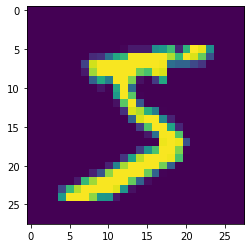

In [30]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

### архитектура модели

In [55]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.do2 = nn.Dropout(dropout_p)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, output_dim)
        
        #self.activation = nn.ReLU()
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.do2(x)
        x = self.bn2(x)
        x = self.linear3(x)
        return x

### формирование батча

In [56]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
    target = torch.from_numpy(numpy.array(target))

    return {
        'data': pics.view(pics.size(0), -1), # B x 784. преобразуем матрицу 28х28 в вектор 784
        'target': target,
    }


### инициализировать модель, оптимизатор, функция потерь

In [57]:
# hyperparams
inp_dim = 28 * 28 #784
hidden1 = 512
hidden2 = 256
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [58]:
model = LinearModel(inp_dim, hidden1, hidden2, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


### трейн луп

In [59]:
for epoch in range(n_epochs):
    # получаем случайное разбиение на батчи
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn,
                            drop_last = True,
                            ) 
    for i, batch in enumerate(dataloader):
        optim.zero_grad() # обнуляем градиенты

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward() # считаем градиенты
        optim.step() # обновляем веса
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')


epoch: 0, step: 0, loss: 2.4843685626983643
epoch: 0, step: 200, loss: 0.20265139639377594
epoch: 0, step: 400, loss: 0.2514208257198334
epoch: 1, step: 0, loss: 0.13172294199466705
epoch: 1, step: 200, loss: 0.18756930530071259
epoch: 1, step: 400, loss: 0.06935643404722214
epoch: 2, step: 0, loss: 0.03690963611006737
epoch: 2, step: 200, loss: 0.07342955470085144
epoch: 2, step: 400, loss: 0.04287679120898247
epoch: 3, step: 0, loss: 0.07990945875644684
epoch: 3, step: 200, loss: 0.05980084836483002
epoch: 3, step: 400, loss: 0.05682367831468582
epoch: 4, step: 0, loss: 0.07258491963148117
epoch: 4, step: 200, loss: 0.03132404759526253
epoch: 4, step: 400, loss: 0.06450797617435455
epoch: 5, step: 0, loss: 0.01831606775522232
epoch: 5, step: 200, loss: 0.017439285293221474
epoch: 5, step: 400, loss: 0.043829284608364105
epoch: 6, step: 0, loss: 0.0437089167535305
epoch: 6, step: 200, loss: 0.011602739803493023
epoch: 6, step: 400, loss: 0.05336065590381622
epoch: 7, step: 0, loss: 0.

## Обучить глубокую сверточную сеть на MNIST

### архитектура модели

In [102]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.pl1 = nn.MaxPool2d(kernel_size=3,padding=1,stride=1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.pl2 = nn.MaxPool2d(kernel_size=3,padding=1,stride=1)
    self.conv3 = nn.Conv2d(hidden_ch, 10, kernel_size=3, padding=1, stride=1) 
    self.classifier = nn.Linear(10 * 14 *14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.do1(x)
    x = self.pl1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.do2(x)
    x = self.pl2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

### формирование батча

In [103]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

### инициализировать модель, оптимизатор, функция потерь

In [110]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [111]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

### трейн луп

In [112]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model_conv(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3841545581817627
epoch: 0, step: 200, loss: 0.12393154203891754
epoch: 0, step: 400, loss: 0.05917760357260704
epoch: 1, step: 0, loss: 0.025861196219921112
epoch: 1, step: 200, loss: 0.09051017463207245
epoch: 1, step: 400, loss: 0.026975836604833603
epoch: 2, step: 0, loss: 0.01085875928401947
epoch: 2, step: 200, loss: 0.07063427567481995
epoch: 2, step: 400, loss: 0.01682581938803196
epoch: 3, step: 0, loss: 0.016163725405931473
epoch: 3, step: 200, loss: 0.03977631777524948
epoch: 3, step: 400, loss: 0.09899717569351196
epoch: 4, step: 0, loss: 0.011704012751579285
epoch: 4, step: 200, loss: 0.0023618999402970076
epoch: 4, step: 400, loss: 0.05271844565868378
epoch: 5, step: 0, loss: 0.0199159923940897
epoch: 5, step: 200, loss: 0.022680973634123802
epoch: 5, step: 400, loss: 0.026213964447379112
epoch: 6, step: 0, loss: 0.027548057958483696
epoch: 6, step: 200, loss: 0.03719800338149071
epoch: 6, step: 400, loss: 0.01739361882209778
epoch: 7, step: 0, l